## 采用关联分析与多层感知机预测虚拟货币走势

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](..)

### 关联分析挖掘时序相关性
- 数据特征筛选
- 关联分析与时序对齐

In [2]:
import pandas as pd
alldata = pd.read_csv('../datasets/alldata.csv',index_col=0)
alldata.index = pd.to_datetime(alldata.index)
alldata

,open,high,low,close,volume,currency_volume,SMA,CCI,ADX,STOCH,...,USDaltcoinVolume24HReported,USDaltcoinMarketCap,googlePrice,googleVolume,METAPrice,METAVolume,APPLEPrice,APPLEVolume,AMAZONPrice,AMAZONVolume
date,,,,,,,,,,,,,,,,,,,,,
2018-02-01,9341.5,9539.9,8050.0,9072.0,24088.322765,2.119027e+08,10485.428571,-186.693718,21.793295,17.497004,...,0.000000e+00,3.447995e+11,59.0795,0,193.09,0,41.9450,0,69.5000,0
2018-02-02,9076.5,9473.1,8260.0,9188.9,13157.413721,1.164154e+08,10158.371429,-163.911277,22.583856,19.498374,...,0.000000e+00,3.005287e+11,55.9600,0,190.28,0,40.1250,0,71.4975,0
2018-02-05,7424.6,7511.3,6032.3,7310.1,45609.867349,3.071916e+08,8743.371429,-200.537306,26.781757,16.259687,...,0.000000e+00,2.558459e+11,53.1195,0,181.26,0,39.1225,0,69.5000,0
2018-02-06,7310.1,8499.9,6810.0,8165.4,28328.116584,2.135674e+08,8477.157143,-125.915130,27.389793,27.143166,...,0.000000e+00,2.117446e+11,54.2215,0,185.31,0,40.7575,0,72.1420,0
2018-02-07,8165.4,8700.8,7400.0,8245.1,5234.161839,4.260795e+07,8320.528571,-97.063097,27.728357,28.157329,...,0.000000e+00,2.403900e+11,52.7705,0,180.18,0,39.8850,0,70.8390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-05,25985.1,26150.0,25350.0,26066.0,20043.683285,5.154237e+08,26776.514286,-215.886678,13.851260,23.060324,...,6.395436e+10,6.191262e+11,126.0100,32305531,271.39,20742946,179.5800,121946497,125.3000,47950128
2023-06-06,26066.1,27399.3,26066.1,26346.2,21251.749633,5.696411e+08,26696.471429,-57.401028,13.026836,32.084769,...,1.415696e+11,5.906678e+11,127.3100,26638295,271.12,19419010,179.2100,64848374,126.6100,45695212
2023-06-07,26343.3,26850.0,26126.0,26733.0,7152.886386,1.890840e+08,26672.842857,-59.381605,12.261300,44.542497,...,1.177489e+11,6.061070e+11,122.5000,52538986,263.60,26163627,177.8200,61944615,121.2300,95663275


### 采用时延相似度来确定时序相关性以及时序对齐

In [3]:
from scipy.signal import correlate,correlation_lags
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
minmax= MinMaxScaler()
## 打算预测多少天后的数据
N = 10
normdata = minmax.fit_transform(alldata)
normdf = pd.DataFrame(normdata,columns=alldata.columns,index=alldata.index)
lagtimes = {}
## 设置测试集比例
testratio = 0.15
normtraindf = normdf.iloc[:-int(len(normdf)*testratio),:]
corrValues ={}
HighEffCol= []
for col in alldata.columns:
    corr = correlate(normtraindf['open'],normtraindf[col])/len(normtraindf['close'])
    lags = correlation_lags(len(normtraindf['open']), len(normtraindf['close']))
    lag,value= lags[np.where(corr==corr.max())][0],corr.max()
    lagtimes[col]= lag
    corrValues[col]= value
    print(col,lag,value)
    ## 如果一个时间序列推迟n天后与目标序列的相关性大于0.1，则认为该序列对目标序列有较大的影响，即可以用n天前的数据来预测目标序列
    if lag>=N and value>0.1:
        HighEffCol.append(col)



open 0 0.14604968110937816
high 0 0.1488686855450336
low 0 0.14631552067020434
close 1 0.14615537854950988
volume 420 0.02817724766071583
currency_volume -4 0.04107146740185305
SMA -1 0.15291598945670812
CCI 255 0.13956953995049465
ADX 55 0.11591875961338163
STOCH 250 0.15602928048535789
ATR -7 0.10141149005496321
upper_bb -4 0.16264963676117286
middle_band -4 0.1572477992028997
lower_bb -4 0.1474443561878932
RSI 198 0.14992418111960648
MOM 20 0.15685428040402852
EMA 0 0.15360766805908768
MACD 29 0.14527628948335344
MACDSingal 32 0.14429181395675603
FearGreedIndex 168 0.1456757489824069
btcDominance 349 0.1963593878744293
ethDominance -59 0.13889313531663994
score 0 0.16431750414418228
activeCryptocurrencies -71 0.14409788303686824
activeMarketPairs -68 0.14306135232800343
activeExchanges 312 0.12209328118859969
totalCryptocurrencies 0 0.14970072420918565
totalExchanges 0 0.02240747611580558
USDtotalMarketCap -1 0.13893969767955489
USDtotalVolume24H 225 0.08332285658970685
USDtotalVolu

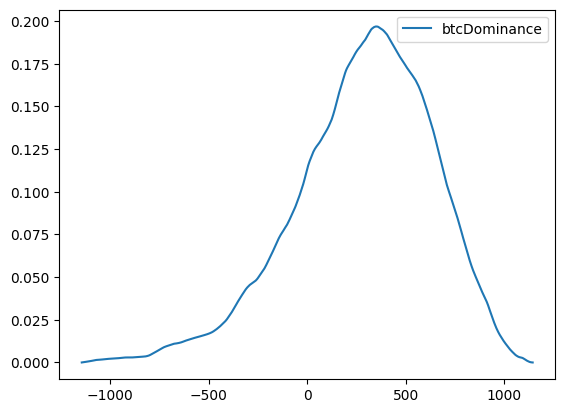

In [4]:
## 举例绘制相位相关图
col  = 'btcDominance'
corr = correlate(normtraindf['close'],normtraindf[col])/len(normtraindf['close'])
lags = correlation_lags(len(normtraindf['close']), len(normtraindf['close']))
## plot
plt.plot(lags, corr,label= col)
plt.legend()

In [5]:
## 查看有效特征列
HighEffCol

['CCI',
 'ADX',
 'STOCH',
 'RSI',
 'MOM',
 'MACD',
 'MACDSingal',
 'FearGreedIndex',
 'btcDominance',
 'activeExchanges',
 'METAPrice',
 'AMAZONPrice']

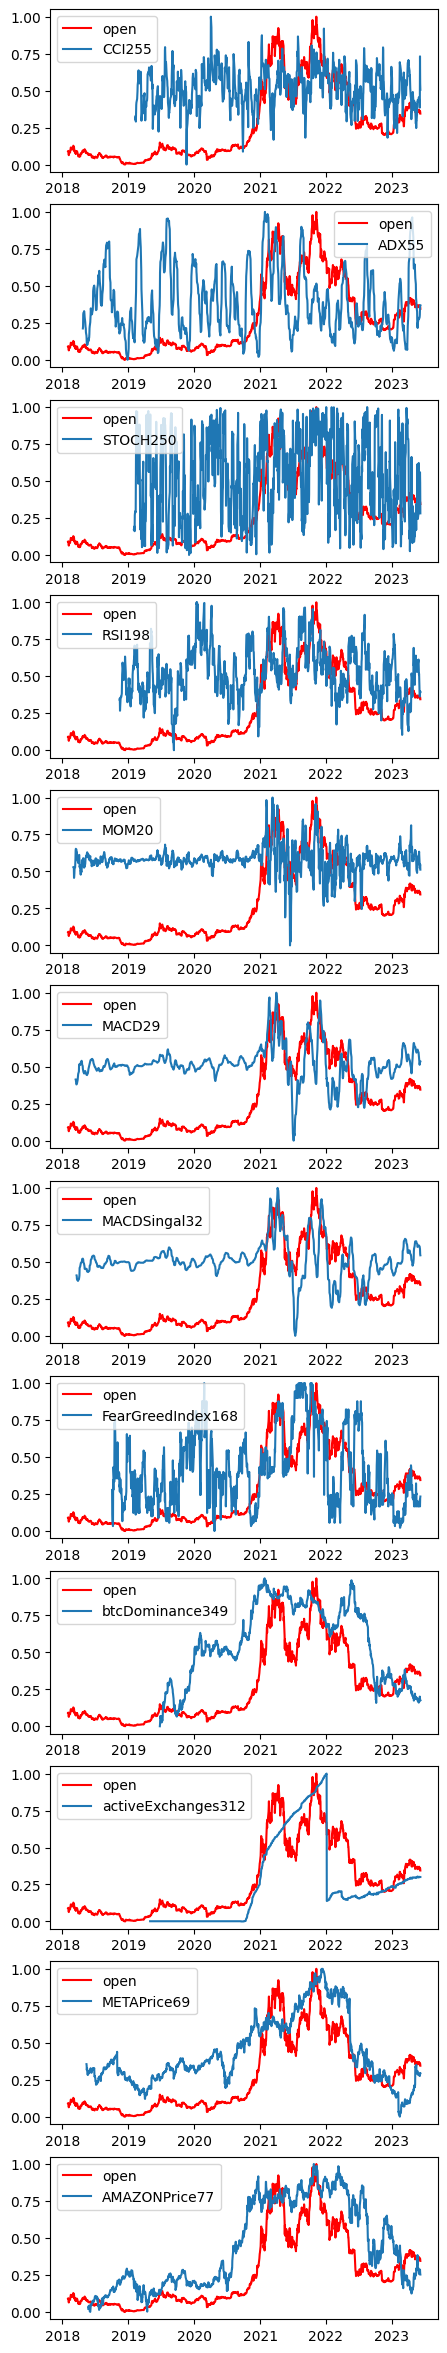

In [6]:
plt.figure(figsize=(5,30))
for i,col in enumerate(HighEffCol,1):
    plt.subplot(len(HighEffCol),1,i)
    plt.plot(normdf.close,'r',label='open')
    plt.plot(normdf[col].shift(lagtimes[col]),label=col+str(lagtimes[col]))
    plt.legend()

In [7]:
import torch
## 构造数据集
def generateData(normdf,HighEffCol,lagtimes,device):
    df = pd.DataFrame()
    df.index = normdf.index
    for i,col in enumerate(HighEffCol,1):

        df[col] = normdf[col].shift(lagtimes[col])
    df['pred'] = normdf.open
    df = df.dropna(axis=0)
    X,y = df.iloc[:,:-1].to_numpy().astype('float32'),df.pred.to_numpy().astype('float32')
    for i in range(len(df)):
        yield torch.tensor(X[i],device=device),torch.tensor(y[i],device=device)
from torch.utils.data import DataLoader
device = torch.device('mps')
batch_size= 32
dataset = list(generateData(normdf,HighEffCol,lagtimes,device))
ratios =[int(len(dataset)*i) for i in [0.7,0.85]]
trainData,valiData,testData = dataset[:ratios[0]], dataset[ratios[0]:ratios[1]],dataset[ratios[1]:]
trainLoader = DataLoader(trainData,batch_size=batch_size,shuffle=True)
valiLoader = DataLoader(valiData,batch_size=batch_size,shuffle=True)
testLoader = DataLoader(testData,batch_size=batch_size)

In [8]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint2.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [9]:
## MLP模型

import torch.nn as nn
class MLP(nn.Module):
    def __init__(self,inputsize,outputsize,hiddensizes):
        super(MLP,self).__init__()
        self.layers = nn.ModuleList()
        
        hiddensizes.insert(0,inputsize)
        hiddensizes.append(outputsize)
        self.hiddensizes = hiddensizes
        for i in range(len(hiddensizes)-1):
            self.layers.append(nn.Linear(hiddensizes[i],hiddensizes[i+1]))
        self.dropout = nn.Dropout( p=0.5)
    def forward(self,input):
        for i in range(len(self.hiddensizes)-1):  
            input = self.layers[i](input)
            # if i ==1:
            #     input = self.dropout(input)
        input = nn.functional.leaky_relu(input)
        input = input.squeeze()
        return input



In [10]:
from tqdm  import tqdm 
import torch
import torch.nn as nn
import torch.nn.functional as F

class CosineLoss(nn.Module):
    def __init__(self, device,xent=100, reduction="mean"):
        super(CosineLoss, self).__init__()
        self.xent = xent
        self.reduction = reduction
        
        self.y = torch.Tensor([1]).to(device)
        
    def forward(self, input, target):
        input = input.view(-1,1)
        target = target.view(-1,1)
        cosine_loss = F.cosine_embedding_loss(input, target, self.y, reduction=self.reduction)
        cent_loss = F.mse_loss(input, target, reduction=self.reduction)
        
        return cosine_loss + self.xent * cent_loss

def train(model,dataloader,validataloader,device,epochNum=10,learningrate=1e-3,decay=0.02,patience=10):
    print(model,dataloader,validataloader,device)
    loss_function = nn.MSELoss().to(device)
    # loss_function = CosineLoss(device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learningrate,
                                      weight_decay=decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)
  # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    print(type(dataloader))
    batchsize = dataloader.batch_size
    for epoch in range(epochNum):
        model.train() # prep model for training
        for batch, (data, target) in tqdm(enumerate(dataloader,1),desc=f'epoch {epoch}:'):
            # if batch >=int(len(dataloader.dataset)/batchsize):
            #     break 
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = loss_function(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
        model.eval() # prep model for evaluation
        for batch, (data, target)in tqdm(enumerate(validataloader,1),desc=f'epoch {epoch}: validate'):
            # if batch >=int(len(validataloader.dataset)/batchsize):
            #     break 
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = loss_function(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        print_msg = (f'epoch: [{epoch}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        scheduler.step()
      # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint2.pt'))
    return  model, avg_train_losses, avg_valid_losses


In [16]:
model = MLP(inputsize=trainData[0][0].size()[0],outputsize=1,hiddensizes=[32,16,4]).to(device)
model,_,_= train(model,trainLoader,valiLoader,device,epochNum=30,learningrate=0.01,patience=10)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=4, bias=True)
    (3): Linear(in_features=4, out_features=1, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
) <torch.utils.data.dataloader.DataLoader object at 0x1699a8eb0> <torch.utils.data.dataloader.DataLoader object at 0x169336640> mps
<class 'torch.utils.data.dataloader.DataLoader'>


epoch 0:: 0it [00:00, ?it/s]

epoch 0:: 22it [00:00, 53.44it/s]
epoch 0: validate: 5it [00:00, 157.46it/s]


epoch: [0] train_loss: 0.04949 valid_loss: 0.00624
Validation loss decreased (inf --> 0.006235).  Saving model ...


epoch 1:: 22it [00:00, 82.23it/s]
epoch 1: validate: 5it [00:00, 320.57it/s]


epoch: [1] train_loss: 0.01832 valid_loss: 0.00631
EarlyStopping counter: 1 out of 10


epoch 2:: 22it [00:00, 98.62it/s]
epoch 2: validate: 5it [00:00, 339.09it/s]


epoch: [2] train_loss: 0.01861 valid_loss: 0.01308
EarlyStopping counter: 2 out of 10


epoch 3:: 22it [00:00, 98.67it/s]
epoch 3: validate: 5it [00:00, 349.67it/s]


epoch: [3] train_loss: 0.01357 valid_loss: 0.00455
Validation loss decreased (0.006235 --> 0.004553).  Saving model ...


epoch 4:: 22it [00:00, 101.32it/s]
epoch 4: validate: 5it [00:00, 344.11it/s]


epoch: [4] train_loss: 0.01221 valid_loss: 0.00512
EarlyStopping counter: 1 out of 10


epoch 5:: 22it [00:00, 99.12it/s] 
epoch 5: validate: 5it [00:00, 361.84it/s]


epoch: [5] train_loss: 0.01386 valid_loss: 0.00743
EarlyStopping counter: 2 out of 10


epoch 6:: 22it [00:00, 101.46it/s]
epoch 6: validate: 5it [00:00, 352.69it/s]


epoch: [6] train_loss: 0.01347 valid_loss: 0.00370
Validation loss decreased (0.004553 --> 0.003696).  Saving model ...


epoch 7:: 22it [00:00, 99.89it/s] 
epoch 7: validate: 5it [00:00, 351.25it/s]


epoch: [7] train_loss: 0.01669 valid_loss: 0.00472
EarlyStopping counter: 1 out of 10


epoch 8:: 22it [00:00, 101.44it/s]
epoch 8: validate: 5it [00:00, 345.97it/s]


epoch: [8] train_loss: 0.01699 valid_loss: 0.00667
EarlyStopping counter: 2 out of 10


epoch 9:: 22it [00:00, 101.65it/s]
epoch 9: validate: 5it [00:00, 353.09it/s]


epoch: [9] train_loss: 0.01206 valid_loss: 0.00685
EarlyStopping counter: 3 out of 10


epoch 10:: 22it [00:00, 101.48it/s]
epoch 10: validate: 5it [00:00, 349.33it/s]


epoch: [10] train_loss: 0.01271 valid_loss: 0.00757
EarlyStopping counter: 4 out of 10


epoch 11:: 22it [00:00, 99.10it/s]
epoch 11: validate: 5it [00:00, 313.28it/s]


epoch: [11] train_loss: 0.01398 valid_loss: 0.01074
EarlyStopping counter: 5 out of 10


epoch 12:: 22it [00:00, 70.50it/s]
epoch 12: validate: 5it [00:00, 329.62it/s]


epoch: [12] train_loss: 0.01270 valid_loss: 0.00654
EarlyStopping counter: 6 out of 10


epoch 13:: 22it [00:00, 98.55it/s]
epoch 13: validate: 5it [00:00, 309.96it/s]


epoch: [13] train_loss: 0.01213 valid_loss: 0.00903
EarlyStopping counter: 7 out of 10


epoch 14:: 22it [00:00, 101.54it/s]
epoch 14: validate: 5it [00:00, 340.46it/s]


epoch: [14] train_loss: 0.01472 valid_loss: 0.00469
EarlyStopping counter: 8 out of 10


epoch 15:: 22it [00:00, 101.56it/s]
epoch 15: validate: 5it [00:00, 365.60it/s]


epoch: [15] train_loss: 0.01520 valid_loss: 0.00375
EarlyStopping counter: 9 out of 10


epoch 16:: 22it [00:00, 101.37it/s]
epoch 16: validate: 5it [00:00, 348.75it/s]

epoch: [16] train_loss: 0.01216 valid_loss: 0.00686
EarlyStopping counter: 10 out of 10
Early stopping


In [17]:

def testLoss(model,testdataloader,device):
    loss_function = nn.MSELoss().to(device)
    batchsize = testdataloader.batch_size
    sum=0
    for batch, (data, target)in tqdm(enumerate(testdataloader,1),desc=f'test validate'):
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = loss_function(output, target)
        # record validation loss
        sum+=loss.item()
    return sum/batch

In [18]:
realLoss = testLoss(model,testLoader,device)
realLoss

test validate: 5it [00:00, 186.23it/s]


0.018968131579458713

In [19]:
pred = [model(x).item() for x,y in dataset]
real = [y.item() for x,y in dataset]

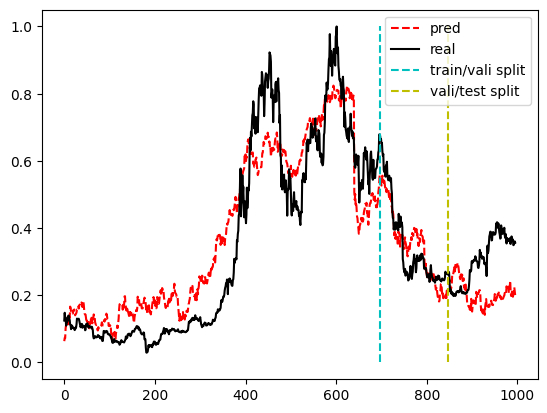

In [20]:
import matplotlib.pyplot as plt
plt.plot(pred,'r--',label= 'pred')
plt.plot(real,'k',label= 'real')
plt.vlines(ratios[0],0,1,colors = "c", linestyles = "dashed",label='train/vali split')
plt.vlines(ratios[1],0,1,colors = "y", linestyles = "dashed",label='vali/test split')
plt.legend()